In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json
import pickle

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.shape

(1628, 29)

In [4]:
df.columns

Index(['Id', 'Age', 'Attrition', 'BusinessTravel', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'CommunicationSkill',
       'Behaviour'],
      dtype='object')

In [5]:
cols_to_drop = ['Id', 'Gender', 'Behaviour', 'MaritalStatus', 'Education', 'Department', 'PerformanceRating',
                'TrainingTimesLastYear', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
df_cleaned = df.drop(cols_to_drop, axis = 1)
len(df_cleaned.columns)

18

In [6]:
object_type = df_cleaned.select_dtypes(include='object').columns
object_type_vals = dict()
for col in object_type:
    object_type_vals[col] = df_cleaned[col].unique().tolist()
with open('data/object_col_unique_vals.json', 'w') as fp:
    json.dump(object_type_vals, fp)
with open('data/object_col_unique_vals.json', 'r') as fp:
    object_type_vals = json.load(fp)
object_type_vals

{'BusinessTravel': ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'],
 'EducationField': ['Medical',
  'Life Sciences',
  'Other',
  'Marketing',
  'Technical Degree',
  'Human Resources'],
 'JobRole': ['Laboratory Technician',
  'Manufacturing Director',
  'Sales Executive',
  'Research Scientist',
  'Sales Representative',
  'Healthcare Representative',
  'Research Director',
  'Human Resources',
  'Manager'],
 'OverTime': ['No', 'Yes']}

In [7]:
df_X = df_cleaned.drop(['Attrition'], axis = 1).copy()
df_y = df_cleaned[['Attrition']].copy()

In [8]:
df_train = df_X.drop(object_type_vals, axis=1)

In [9]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='error', sparse=False, drop='first')
encoder = ohe.fit(df_X[object_type])
object_type_onehot_arr = encoder.transform(df_X[object_type])

In [10]:
X = np.hstack((df_train.values,object_type_onehot_arr))
y = df_y.values

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
y_train, y_test = y_train.ravel(), y_test.ravel()

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

### Testing Several models

In [14]:
def check_model_perf(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    print(model.__class__)
    print('-'*50)
    print("True Possitives  :\t{}\nTrue Negatives   :\t{}\nFalse Possitives :\t{}\nFalse Negatives  :\t{}".format(tp,tn,fp,fn))
    auc_score = metrics.roc_auc_score(y_test, predictions)
    print("AUC Score : {}".format(auc_score))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
    sns.lineplot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    return auc_score

In [15]:
scores = dict()

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
--------------------------------------------------
True Possitives  :	221
True Negatives   :	249
False Possitives :	10
False Negatives  :	9
AUC Score : 0.9611297633036764


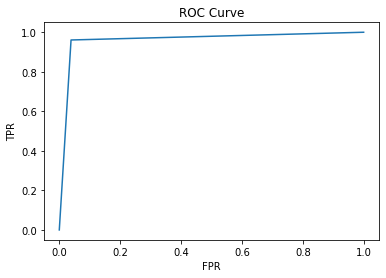

In [16]:
scores['Random Forest'] = check_model_perf(RandomForestClassifier(n_estimators=30), X_train, y_train, X_test, y_test)

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
--------------------------------------------------
True Possitives  :	225
True Negatives   :	217
False Possitives :	42
False Negatives  :	5
AUC Score : 0.9080493537015275


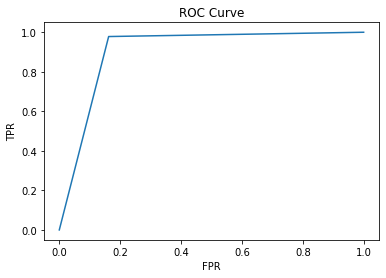

In [17]:
scores['Decision Tree'] = check_model_perf(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

<class 'sklearn.svm._classes.SVC'>
--------------------------------------------------
True Possitives  :	208
True Negatives   :	213
False Possitives :	46
False Negatives  :	22
AUC Score : 0.8633708242403895


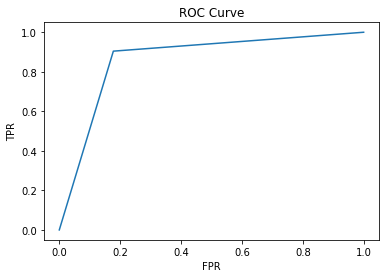

In [18]:
scores['SVC'] = check_model_perf(SVC(), X_train, y_train, X_test, y_test)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
--------------------------------------------------
True Possitives  :	174
True Negatives   :	203
False Possitives :	56
False Negatives  :	56
AUC Score : 0.7701527614571093


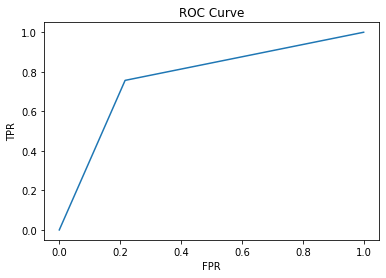

In [19]:
scores['Logistic Regression'] = check_model_perf(LogisticRegression(), X_train, y_train, X_test, y_test)

<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
--------------------------------------------------
True Possitives  :	178
True Negatives   :	175
False Possitives :	84
False Negatives  :	52
AUC Score : 0.7247943595769683


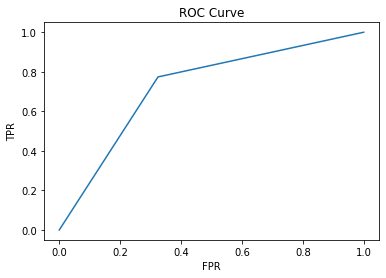

In [20]:
scores['SGD Classifier'] = check_model_perf(SGDClassifier(), X_train, y_train, X_test, y_test)

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
--------------------------------------------------
True Possitives  :	201
True Negatives   :	209
False Possitives :	50
False Negatives  :	29
AUC Score : 0.8404314252140339


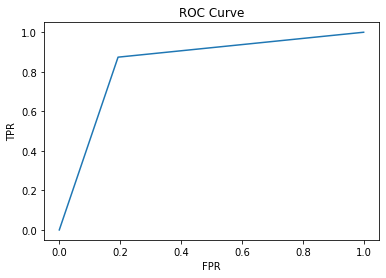

In [21]:
scores['AdaBoost'] = check_model_perf(AdaBoostClassifier(n_estimators=200), X_train, y_train, X_test, y_test)

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
--------------------------------------------------
True Possitives  :	225
True Negatives   :	209
False Possitives :	50
False Negatives  :	5
AUC Score : 0.8926053382575121


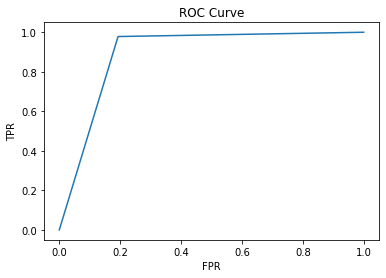

In [22]:
scores['NNet'] = check_model_perf(MLPClassifier(hidden_layer_sizes=(15,10),max_iter=600), X_train, y_train, X_test, y_test)

In [23]:
pd.DataFrame.from_dict(scores, orient='index', columns=['AUC Score']).sort_values(by=['AUC Score'], ascending=False)

,AUC Score
Random Forest,0.961130
Decision Tree,0.908049
NNet,0.892605
SVC,0.863371
AdaBoost,0.840431
Logistic Regression,0.770153
SGD Classifier,0.724794


**Clearly, linear models doesn't suit**

In [24]:
!mkdir models

mkdir: models: File exists


### Building A few Models with CV

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
y = y.ravel()

In [27]:
gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'n_estimators': [10, 20, 30, 40, 50],
            'max_features': ['log2','auto','None']
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y.ravel())
print(grid_result.best_params_)
print(grid_result.best_score_)

{'max_features': 'log2', 'n_estimators': 30}
1.0


In [28]:
gsc = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid={
            'criterion': ['gini','entropy'],
            'splitter': ['best','random']
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y.ravel())
print(grid_result.best_params_)
print(grid_result.best_score_)

{'criterion': 'gini', 'splitter': 'best'}
0.9377359819667512


In [29]:
gsc = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid={
            'criterion': ['gini','entropy'],
            'splitter': ['best','random']
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y.ravel())
print(grid_result.best_params_)
print(grid_result.best_score_)

{'criterion': 'gini', 'splitter': 'best'}
0.9389088475626938


In [30]:
gsc = GridSearchCV(
        estimator=SVC(),
        param_grid={
            'kernel': ['rbf','poly'],
            'degree': [3],
            'gamma':['scale','auto']
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
0.9783323731633382


In [31]:
gsc = GridSearchCV(
        estimator=MLPClassifier(),
        param_grid={
            'hidden_layer_sizes': [(20,10),(15,10),(15,15)],
            'max_iter': [200,500,600]
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'hidden_layer_sizes': (20, 10), 'max_iter': 600}
0.9680171412777978


### Some CV Scores for models on interest

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
model = RandomForestClassifier(n_estimators=20)
cross_val_score(model, X, y, cv=20).mean()

0.9791327913279133

In [34]:
model = MLPClassifier(hidden_layer_sizes=(20,10), max_iter=500)
cross_val_score(model, X, y, cv=20).mean()

0.9287789822342669

In [35]:
model = RandomForestClassifier(max_features=0.30, n_estimators=200, oob_score=True)
cross_val_score(model, X, y, cv=10).mean()

0.9803453760508976

### Models_for_submission

In [36]:
!mkdir models

mkdir: models: File exists


Model_name: RandomForest1.0

In [37]:
model = RandomForestClassifier(n_estimators=20)
model.fit(X,y)
pkl_filename = "models/RandomForest1.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

model_name = MLP1.0

In [38]:
model = MLPClassifier(hidden_layer_sizes=(20,10), max_iter=500)
model.fit(X,y)
pkl_filename = "models/MLP1.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

model_name = RandomForest2.0

In [39]:
model = RandomForestClassifier(max_features=0.30, n_estimators=200, oob_score=True)
model.fit(X,y)
pkl_filename = "models/RandomForest2.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)